# Description


This notebook trains, tests and creates plots for the base autoencoder model with 4 hidden layers each for the encoder and decoder, and the latent space is of dimensions 3. 

* This is the **same** model as in Eric Wulff and Erik Wallin's codes for 4-momentum data compression. 

* Tanh activatation is used for the hidden layers as the data is normalized.

*The data used in this notebook was normalized using standard normalization. Refer 4D_data_normalization.ipynb for further details.*

*Please note that to generate the train-validation loss plot, the test set is treated as the validation set, which theoretically is incorrect. However, I did not use the test set performance to determine the training schedule, so except for the loss plot, the test set is independent.*

### Load packages

In [1]:
import sys
BIN = 'utils/'
sys.path.append(BIN)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import fastai
from fastai.callbacks import ActivationStats
from fastai import data_block, basic_train, basic_data

import matplotlib as mpl
import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')
%matplotlib inline

In [2]:
from utils import plot_activations
from nn_utils import AE_3D_200

### Check for gpu

In [3]:
torch.cuda.is_available()

True

***Comment if you training is to be done on a CPU***

In [4]:
fastai.torch_core.defaults.device = 'cuda'

## Load data

In [5]:
train = pd.read_pickle('../datasets/non_normalized_train_4D_100_percent').astype(np.float32)
test = pd.read_pickle('../datasets/non_normalized_test_4D_100_percent').astype(np.float32)

train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

n_features = len(train.loc[0])

train.head(10)

,m,pt,phi,eta
132784,-0.688495,-0.607621,0.868113,0.759044
99666,-0.587356,-0.612664,-1.487545,0.117475
26629,1.051903,1.503482,-1.081409,0.773109
80473,0.788042,1.697704,-0.911075,1.813981
48229,-0.578691,-0.628708,1.619720,-0.830119
61832,-0.364435,-0.492946,-1.644025,0.033356
26867,1.190313,2.021417,1.370299,-0.926961
46232,-0.641407,-0.628926,-1.075396,-1.337245
44194,-0.593361,-0.506088,1.498147,-1.235854
59782,-0.292616,-0.545600,0.744685,-1.825016


### Create database for training

In [6]:
train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [7]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [8]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=8192)

In [9]:
db = basic_data.DataBunch(train_dl, valid_dl)
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f1477533c18>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f1477533b00>;

Test: None

## Model definition

In [10]:
model = AE_3D_200()

### Loss = MSE

In [11]:
loss_func = nn.MSELoss()

### Training parameters

In [12]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

### Find learning rate

In [13]:
from fastai import train as tr
tr.lr_find(learn)

epoch,train_loss,valid_loss,time
0,1.018816,#na#,00:01
1,1.017144,#na#,00:01
2,1.011894,#na#,00:01
3,0.923108,#na#,00:01
4,0.730824,#na#,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


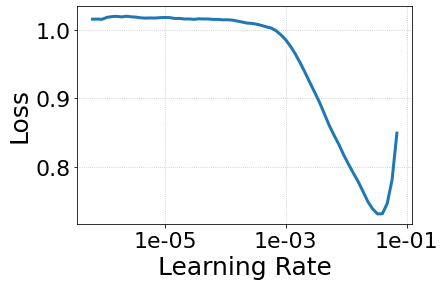

In [14]:
learn.recorder.plot()

### Start training

In [15]:
lr = 1e-6
learn.fit(1, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,1.017480,1.034021,00:02


### Train for 10 epochs with high learning rate

In [16]:
lr = 1e-3
learn.fit(10, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.790731,0.462657,00:01
1,0.501111,0.217051,00:02
2,0.354763,0.143032,00:02
3,0.266674,0.099700,00:01
4,0.205610,0.071794,00:01
5,0.161533,0.056643,00:02
6,0.129511,0.048093,00:01
7,0.105734,0.043484,00:02
8,0.088040,0.041017,00:01
9,0.075608,0.042463,00:02


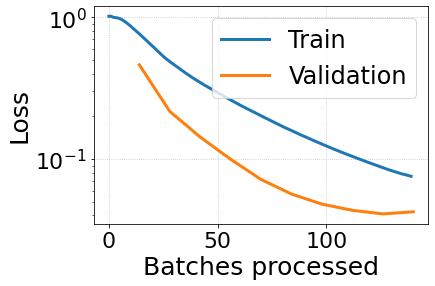

In [17]:
learn.recorder.plot_losses()
plt.yscale('log')

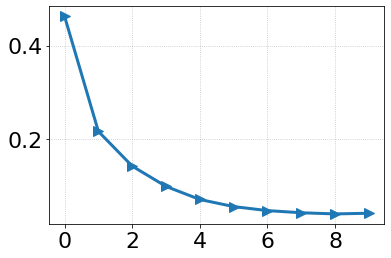

In [18]:
plt.plot(learn.recorder.val_losses, marker='>')

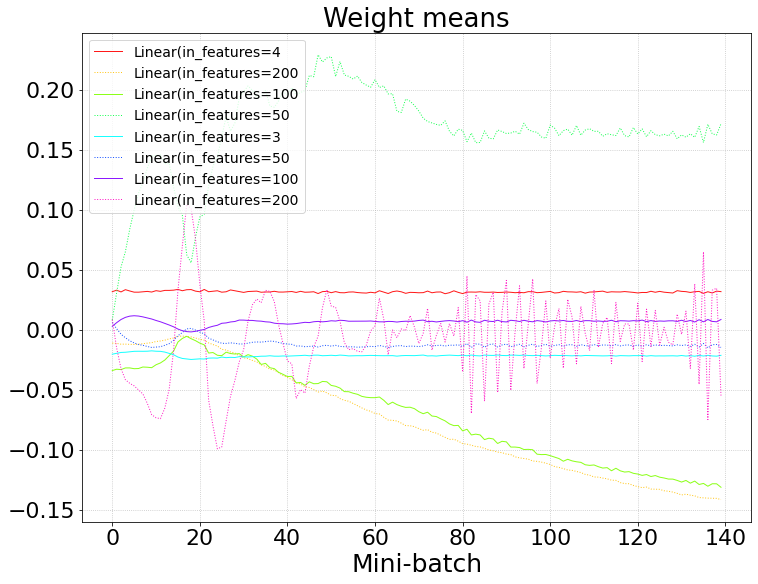

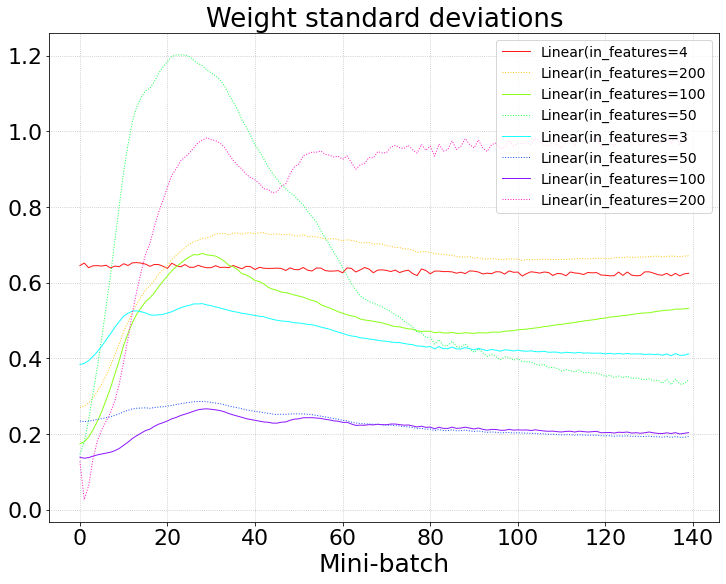

In [19]:
plot_activations(learn)

In [20]:
learn.save('AE_3D_200_no1cycle_std_norm')

### Train for 100 more epochs

In [22]:
lr = 1e-3
learn.fit(100, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.071787,0.061878,00:02
1,0.056502,0.046670,00:02
2,0.049281,0.041218,00:02
3,0.044555,0.038490,00:02
4,0.041389,0.037258,00:02
5,0.039218,0.036593,00:02
6,0.037691,0.036131,00:02
7,0.036537,0.035710,00:02
8,0.035624,0.035422,00:02
9,0.034878,0.035060,00:02


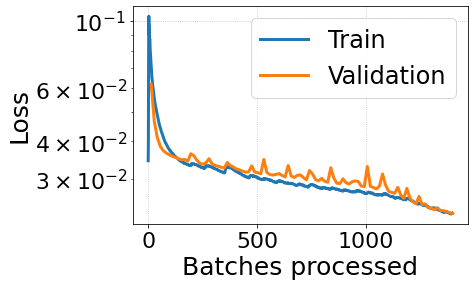

In [23]:
learn.recorder.plot_losses()
plt.yscale('log')

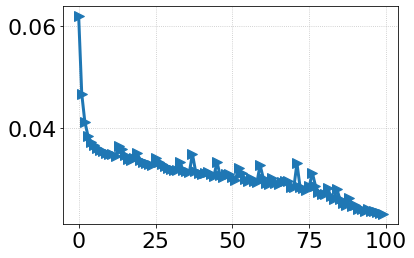

In [24]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [25]:
learn.save('AE_3D_200_no1cycle_std_norm')

### Train for 1000 more epochs at lower LR

In [41]:
lr = 1e-5
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.013185,0.013857,00:02
1,0.013191,0.013840,00:02
2,0.013161,0.013825,00:02
3,0.013152,0.013815,00:02
4,0.013147,0.013807,00:02
5,0.013148,0.013798,00:02
6,0.013148,0.013787,00:02
7,0.013134,0.013777,00:02
8,0.013129,0.013768,00:02
9,0.013128,0.013758,00:02


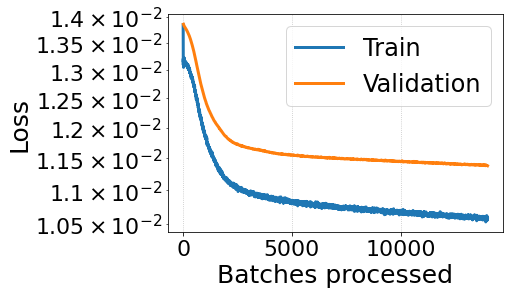

In [42]:
learn.recorder.plot_losses()
plt.yscale('log')

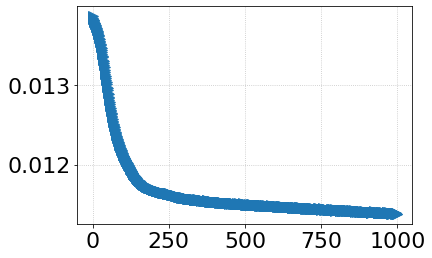

In [43]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [44]:
learn.save('AE_3D_200_no1cycle_std_norm')

### Train for 1000 more epochs

In [38]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010682,0.011421,00:02
1,0.010710,0.011421,00:02
2,0.010691,0.011421,00:02
3,0.010685,0.011421,00:02
4,0.010676,0.011421,00:02
5,0.010660,0.011421,00:02
6,0.010666,0.011422,00:02
7,0.010679,0.011421,00:02
8,0.010675,0.011422,00:02
9,0.010671,0.011422,00:02


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_losses()
plt.yscale('log')

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [ ]:
learn.save('AE_3D_200_no1cycle_std_norm')

### Train for 1000 more epochs

In [35]:
lr = 1e-5
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.023046,0.023651,00:02
1,0.023002,0.023649,00:02
2,0.023018,0.023647,00:02
3,0.023022,0.023645,00:02
4,0.023007,0.023643,00:02
5,0.023018,0.023642,00:02
6,0.023039,0.023640,00:01
7,0.023025,0.023639,00:01
8,0.023052,0.023636,00:02
9,0.023023,0.023634,00:01


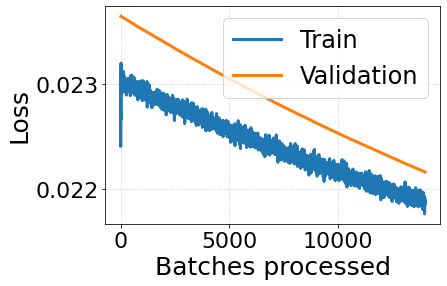

In [36]:
learn.recorder.plot_losses()
# plt.yscale('log')

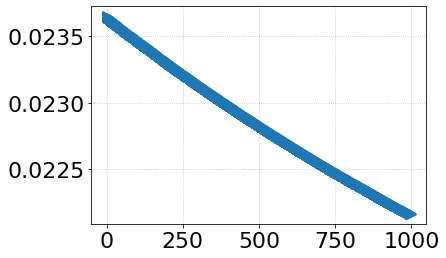

In [37]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [38]:
learn.save('AE_3D_200_no1cycle_std_norm')

### 1000 more ..

In [45]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010567,0.011383,00:02
1,0.010569,0.011383,00:02
2,0.010581,0.011382,00:02
3,0.010574,0.011383,00:02
4,0.010571,0.011383,00:02
5,0.010561,0.011383,00:02
6,0.010556,0.011383,00:02
7,0.010553,0.011384,00:02
8,0.010558,0.011383,00:02
9,0.010565,0.011384,00:02


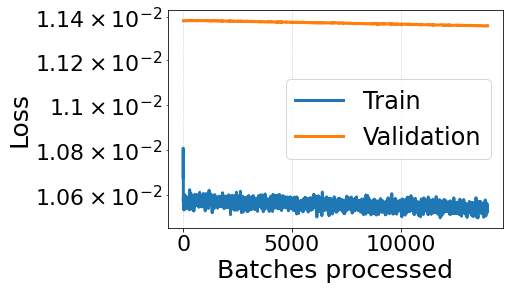

In [46]:
learn.recorder.plot_losses()
plt.yscale('log')

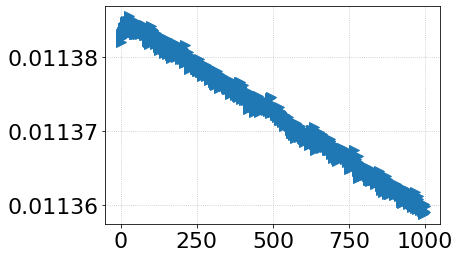

In [47]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [48]:
learn.save('AE_3D_200_no1cycle_std_norm')

### 1000 more ...

In [49]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010541,0.011359,00:02
1,0.010536,0.011360,00:02
2,0.010543,0.011360,00:02
3,0.010538,0.011360,00:02
4,0.010539,0.011360,00:02
5,0.010543,0.011360,00:02
6,0.010547,0.011359,00:02
7,0.010543,0.011359,00:02
8,0.010548,0.011360,00:02
9,0.010549,0.011359,00:02


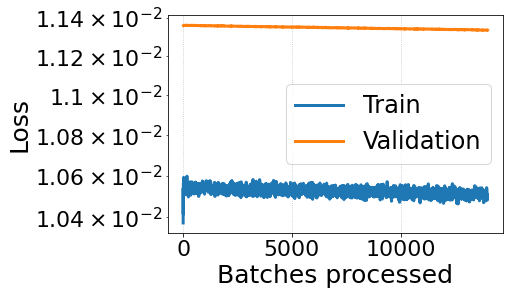

In [50]:
learn.recorder.plot_losses()
plt.yscale('log')

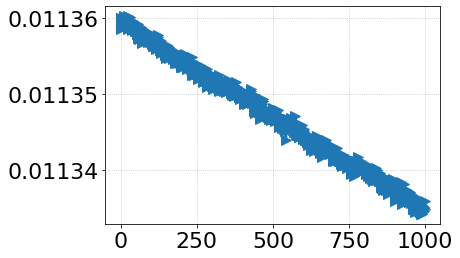

In [51]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [52]:
learn.save('AE_3D_200_no1cycle_std_norm')

### Few more..

In [53]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010495,0.011335,00:02
1,0.010496,0.011334,00:02
2,0.010505,0.011336,00:02
3,0.010525,0.011335,00:02
4,0.010532,0.011334,00:02
5,0.010529,0.011335,00:02
6,0.010530,0.011335,00:02
7,0.010516,0.011335,00:02
8,0.010520,0.011335,00:02
9,0.010517,0.011334,00:02


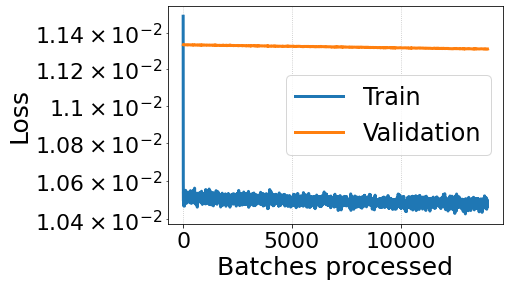

In [54]:
learn.recorder.plot_losses()
plt.yscale('log')

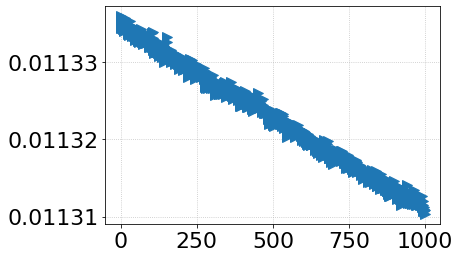

In [55]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [56]:
learn.save('AE_3D_200_no1cycle_std_norm')

In [57]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010495,0.011311,00:02
1,0.010478,0.011311,00:02
2,0.010486,0.011312,00:02
3,0.010477,0.011311,00:02
4,0.010475,0.011311,00:02
5,0.010483,0.011311,00:02
6,0.010480,0.011311,00:02
7,0.010487,0.011310,00:02
8,0.010488,0.011310,00:02
9,0.010476,0.011310,00:02


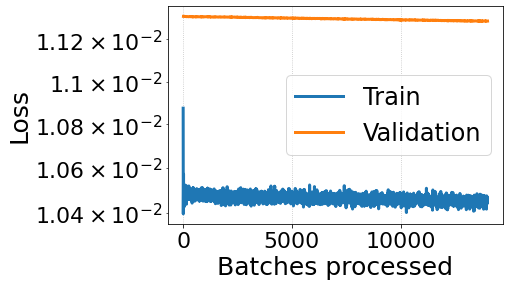

In [58]:
learn.recorder.plot_losses()
plt.yscale('log')

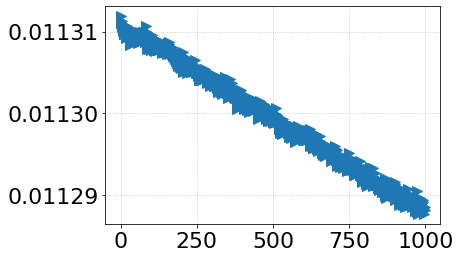

In [59]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [60]:
learn.save('AE_3D_200_no1cycle_std_norm')

In [66]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010409,0.011262,00:02
1,0.010428,0.011263,00:02
2,0.010439,0.011263,00:02
3,0.010433,0.011264,00:02
4,0.010429,0.011262,00:02
5,0.010425,0.011263,00:02
6,0.010430,0.011263,00:02
7,0.010422,0.011263,00:02
8,0.010421,0.011263,00:02
9,0.010427,0.011264,00:02


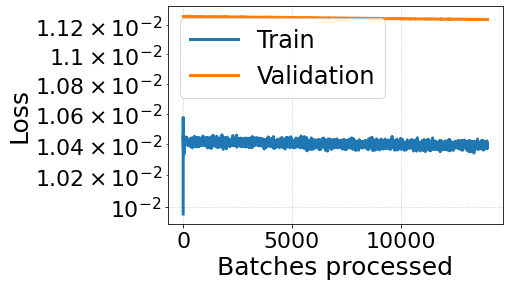

In [67]:
learn.recorder.plot_losses()
plt.yscale('log')

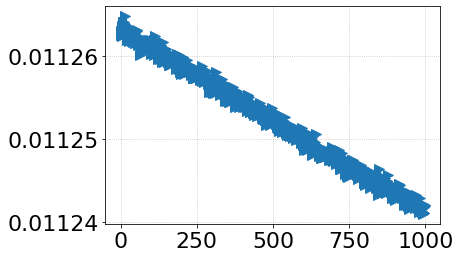

In [68]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [69]:
learn.save('AE_3D_200_no1cycle_std_norm')

In [70]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010370,0.011242,00:02
1,0.010375,0.011242,00:02
2,0.010370,0.011242,00:02
3,0.010380,0.011242,00:02
4,0.010380,0.011241,00:02
5,0.010368,0.011242,00:02
6,0.010370,0.011241,00:02
7,0.010381,0.011242,00:02
8,0.010378,0.011241,00:02
9,0.010389,0.011241,00:02


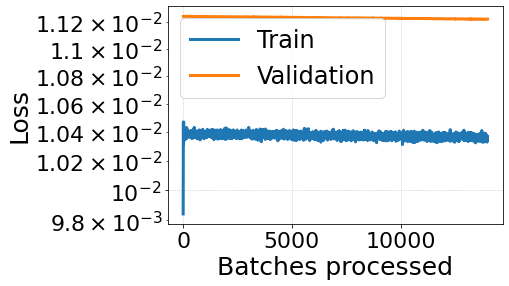

In [71]:
learn.recorder.plot_losses()
plt.yscale('log')

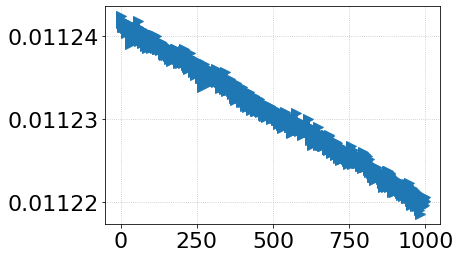

In [72]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [73]:
learn.save('AE_3D_200_no1cycle_std_norm')

In [78]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010324,0.011198,00:02
1,0.010321,0.011199,00:02
2,0.010335,0.011198,00:02
3,0.010340,0.011199,00:02
4,0.010339,0.011200,00:02
5,0.010339,0.011199,00:02
6,0.010339,0.011199,00:02
7,0.010334,0.011198,00:02
8,0.010338,0.011198,00:02
9,0.010343,0.011198,00:02


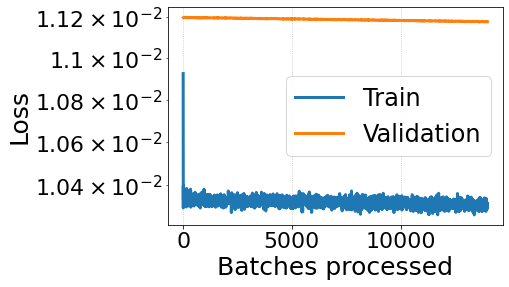

In [79]:
learn.recorder.plot_losses()
plt.yscale('log')

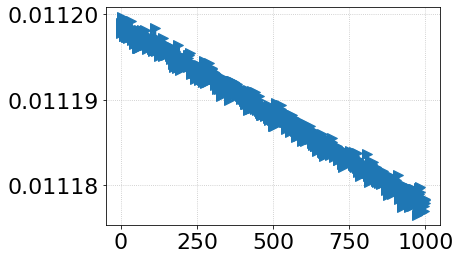

In [80]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [81]:
learn.save('AE_3D_200_no1cycle_std_norm')

In [82]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010303,0.011178,00:02
1,0.010292,0.011177,00:02
2,0.010309,0.011177,00:02
3,0.010299,0.011178,00:02
4,0.010300,0.011177,00:02
5,0.010304,0.011179,00:02
6,0.010308,0.011177,00:02
7,0.010304,0.011177,00:02
8,0.010313,0.011177,00:02
9,0.010317,0.011177,00:02


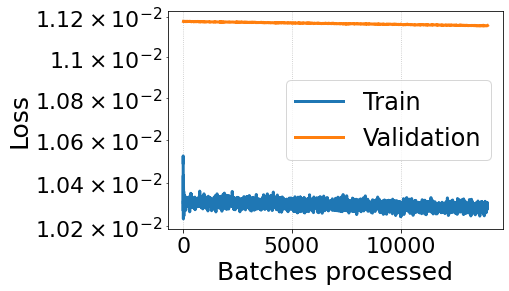

In [83]:
learn.recorder.plot_losses()
plt.yscale('log')

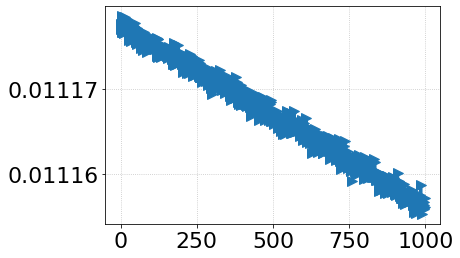

In [84]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [85]:
learn.save('AE_3D_200_no1cycle_std_norm')

In [86]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010285,0.011157,00:02
1,0.010283,0.011156,00:02
2,0.010280,0.011156,00:02
3,0.010284,0.011155,00:02
4,0.010284,0.011155,00:02
5,0.010282,0.011157,00:02
6,0.010287,0.011155,00:02
7,0.010294,0.011156,00:02
8,0.010287,0.011156,00:02
9,0.010282,0.011155,00:02


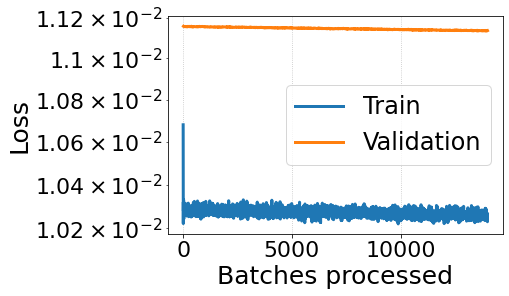

In [87]:
learn.recorder.plot_losses()
plt.yscale('log')

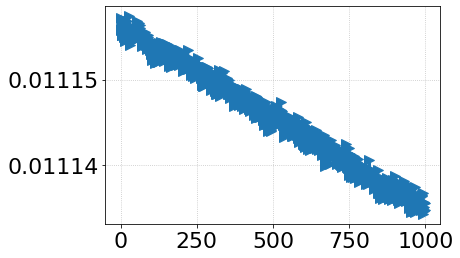

In [88]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [89]:
learn.save('AE_3D_200_no1cycle_std_norm')

In [90]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010266,0.011136,00:02
1,0.010256,0.011135,00:02
2,0.010252,0.011136,00:02
3,0.010249,0.011135,00:02
4,0.010250,0.011135,00:02
5,0.010252,0.011135,00:02
6,0.010257,0.011134,00:02
7,0.010253,0.011135,00:02
8,0.010256,0.011134,00:02
9,0.010266,0.011136,00:02


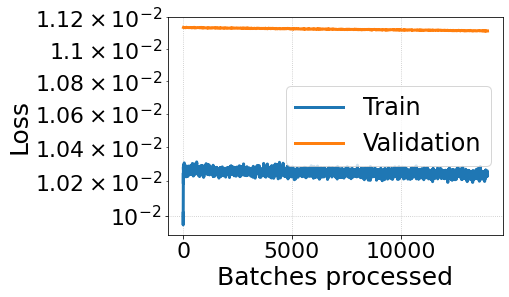

In [91]:
learn.recorder.plot_losses()
plt.yscale('log')

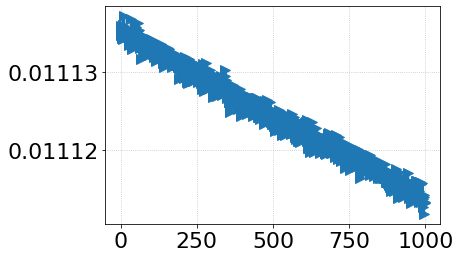

In [92]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
#plt.yscale('log')

In [93]:
learn.save('AE_3D_200_no1cycle_std_norm')

## Test the model and build plots

In [13]:
learn.load('AE_3D_200_no1cycle_std_norm')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f1477533c18>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f1477533b00>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, 

### Evaluate on the test-set

In [14]:
model.to('cuda')
learn.validate()

[0.011113431]

In [16]:
curr_save_folder = 'plots/AE_3D_200_std_norm/'

In [17]:
train.keys()

Index(['m', 'pt', 'phi', 'eta'], dtype='object')

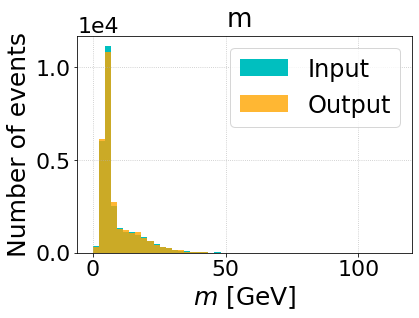

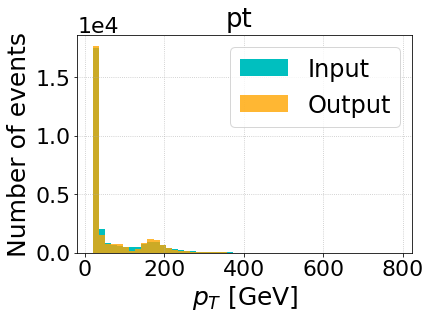

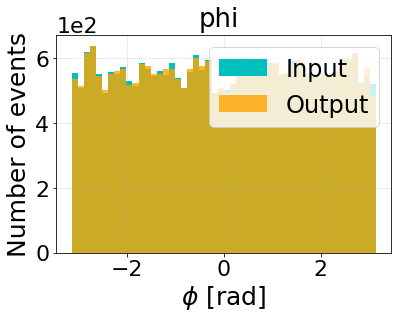

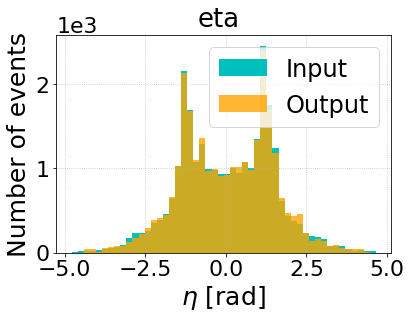

In [18]:
import utils
plt.close('all')
unit_list = ['[GeV]', '[GeV]', '[rad]', '[rad]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$', ]
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, len(test))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
data = data.detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = '200_cus_norm_hist_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

m Mean:  0.0012500082 \pm 0.0007543240624768823  Sigma:  0.12609628 \pm 0.0005333781421335592
pt Mean:  0.015785357 \pm 0.0007534134178278426  Sigma:  0.12594405 \pm 0.0005327342191269719
phi Mean:  -0.01810376 \pm 0.01732333792051837  Sigma:  2.8958488 \pm 0.012249230873326765
eta Mean:  0.05977796 \pm 0.04229594541802272  Sigma:  7.0703845 \pm 0.02990721532030228


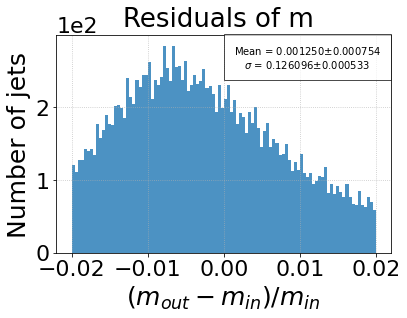

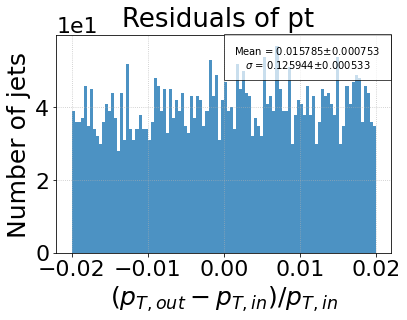

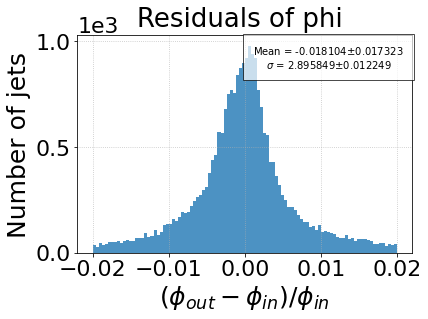

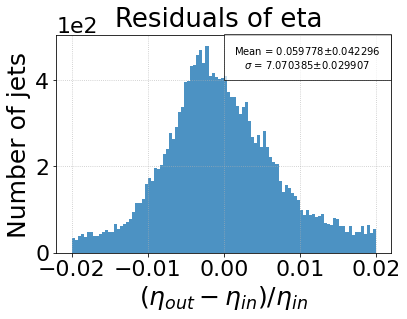

In [19]:
import utils
from scipy import stats
residual_strings = [r'$(m_{out} - m_{in}) / m_{in}$',
                    r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                    r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                    r'$(\eta_{out} - \eta_{in}) / \eta_{in}$']

data[:,0][(data[:,0]<1e-3)] += 1
residuals = np.true_divide(pred - data, data)

range = (-.02, .02)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    print(train.columns[kk],'Mean: ', mean, '\pm', sem, ' Sigma: ', std, '\pm', std_err )
    plt.text(.75, .9, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
    fig_name = '200_cus_norm_residual_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

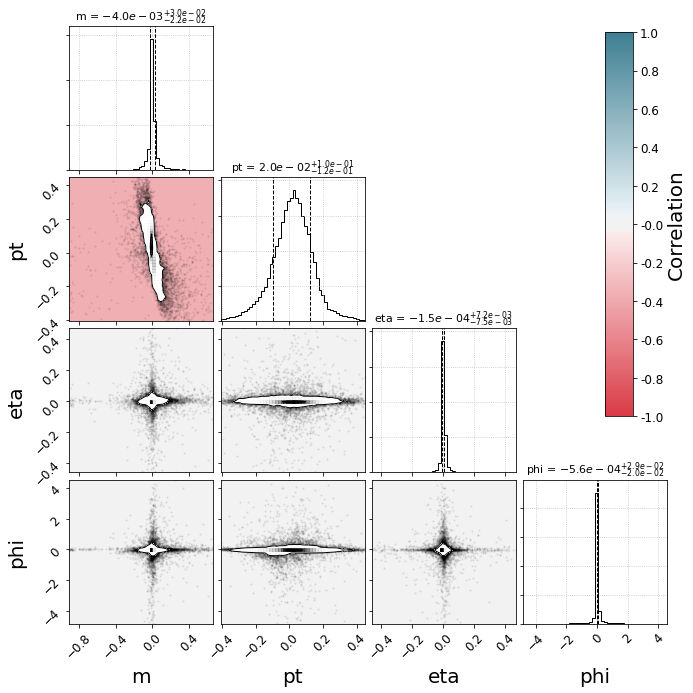

In [20]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'m': residuals[:, 0], 'pt': residuals[:, 1], 'phi': residuals[:, 2], 'eta': residuals[:, 3]})
save = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['m', 'pt', 'eta', 'phi']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = '200_cus_norm_corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)